In [1]:
import sys

sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [2]:
from source.datasets.brain_dataset import BrainDataset
from source.loftr.backbone import ResNetFPN_16_4
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.loftr.fine_preprocess import FinePreprocess
from source.loftr.loss import *
from source.visualization.evaluation_visualization import plot_loss_curve
from torch.utils.data import DataLoader
import torch
from einops.einops import rearrange

In [3]:
crop_size = 640
transformation_threshold = 0.15
patch_size = 16
max_translation_shift = 50
fine_feature_size = 160
images_directory = "../../data/cyto_downscaled_3344_3904/"

dataset_test = BrainDataset(
    images_directory=images_directory,
    train=False,
    transformation_threshold=transformation_threshold,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_feature_size=fine_feature_size,
)

dataloader_test = DataLoader(
    dataset=dataset_test,
    batch_size=1,
    shuffle=True,
    pin_memory=False,
    drop_last=True,
)

In [4]:
model_name = "learning_rate0p0005_weight_decay0p001_use_coarse_contextTrue_image_size3344_3904_ResNetResNetFPN_16_4_transformation_threshold0p25_temperature0p2_batch_size2_v1"

In [5]:
confidence_threshold = 0.3

block_dimensions = [64, 96, 128, 192]
fine_feature_size = block_dimensions[1]
coarse_feature_size = block_dimensions[-1]
backbone = ResNetFPN_16_4(block_dimensions=block_dimensions).cuda()
backbone.load_state_dict(torch.load(f"../../models/{model_name}/backbone.pt"))


positional_encoding = PositionalEncoding(coarse_feature_size).cuda()

coarse_loftr = LocalFeatureTransformer(
    feature_dimension=coarse_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"] * 4,
).cuda()
coarse_loftr.load_state_dict(torch.load(f"../../models/{model_name}/coarse_loftr.pt"))

coarse_matcher = CoarseMatching(temperature=0.1, confidence_threshold=confidence_threshold).cuda()

fine_preprocess = FinePreprocess(
    coarse_feature_size=coarse_feature_size,
    fine_feature_size=fine_feature_size,
    window_size=5,
    use_coarse_context=False,
).cuda()

fine_loftr = LocalFeatureTransformer(
    feature_dimension=fine_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"],
).cuda()
fine_loftr.load_state_dict(torch.load(f"../../models/{model_name}/fine_loftr.pt"))


fine_matching = FineMatching().cuda()

params = list(backbone.parameters()) + list(coarse_loftr.parameters())
optimizer = torch.optim.Adam(params, weight_decay=0.001, lr=0.0008)

In [6]:
backbone.eval()
coarse_loftr.eval()
fine_loftr.eval()

LocalFeatureTransformer(
  (layers): ModuleList(
    (0-1): 2 x LoFTREncoderLayer(
      (q_projection): Linear(in_features=96, out_features=96, bias=False)
      (k_projection): Linear(in_features=96, out_features=96, bias=False)
      (v_projection): Linear(in_features=96, out_features=96, bias=False)
      (attention): LinearAttention()
      (merge): Linear(in_features=96, out_features=96, bias=False)
      (mlp): Sequential(
        (0): Linear(in_features=192, out_features=192, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=192, out_features=96, bias=False)
      )
      (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
  )
)

In [7]:
import numpy as np
confusion_matrix_total = np.zeros((2, 2))

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

No loss history since reinfement loss cant be defined if dependent on predicted match_matrix (since model will then also predict relative coordinates for wrong coarse matches that are not part of ground truth relative coordinates)

In [9]:
with torch.no_grad():
    for epoch in range(30):
        for (
            image_1_crop,
            image_2_crop,
            match_matrix_ground_truth,
            relative_coordinates,
            crop_coordinate_mapping,
        ) in dataloader_test:
            image_1_crop = image_1_crop.cuda()
            image_2_crop = image_2_crop.cuda()
            match_matrix_ground_truth = match_matrix_ground_truth.cuda()
            relative_coordinates = relative_coordinates.cuda()

            coarse_image_feature_1, fine_image_feature_1 = backbone(image_1_crop)
            coarse_image_feature_2, fine_image_feature_2 = backbone(image_2_crop)

            coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
            coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

            coarse_image_feature_1 = rearrange(
                coarse_image_feature_1, "n c h w -> n (h w) c"
            )
            coarse_image_feature_2 = rearrange(
                coarse_image_feature_2, "n c h w -> n (h w) c"
            )

            coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(
                coarse_image_feature_1, coarse_image_feature_2
            )

            coarse_matches_predicted = coarse_matcher(coarse_image_feature_1, coarse_image_feature_2)
            match_matrix_predicted = coarse_matches_predicted["match_matrix"]
            confusion_matrix_total += confusion_matrix(match_matrix_ground_truth.cpu().flatten(), match_matrix_predicted.cpu().flatten())

            print(fine_image_feature_1.shape)

            fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_preprocess(
                coarse_image_feature_1=coarse_image_feature_1,
                coarse_image_feature_2=coarse_image_feature_2,
                fine_image_feature_1=fine_image_feature_1,
                fine_image_feature_2=fine_image_feature_2,
                coarse_matches=coarse_matches_predicted,
                fine_height=160,
                coarse_height=40,
            )

            fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_loftr(
                fine_image_feature_1_unfold, fine_image_feature_2_unfold
            )

            predicted_relative_coordinates = fine_matching(
                fine_image_feature_1_unfold, fine_image_feature_2_unfold
            )
            break
        break

torch.Size([1, 96, 160, 160])


In [10]:
coarse_matches_predicted["match_matrix"].sum()

tensor(879, device='cuda:0')

In [11]:
coarse_matches_predicted["batch_indices"].shape

torch.Size([879])

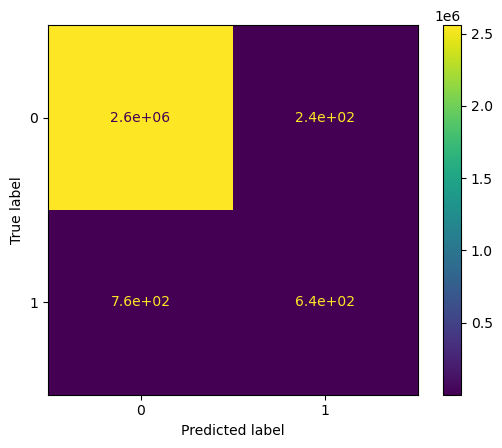

In [12]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_total)
disp.plot()

In [13]:
tn, fp, fn, tp = confusion_matrix_total.ravel()

In [14]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}")

Precision: 0.7258248009101251, Recall: 0.45571428571428574, Accuracy: 0.999608203125


In [15]:
from source.visualization.image_visualization import plot_images_with_matches_via_match_matrix

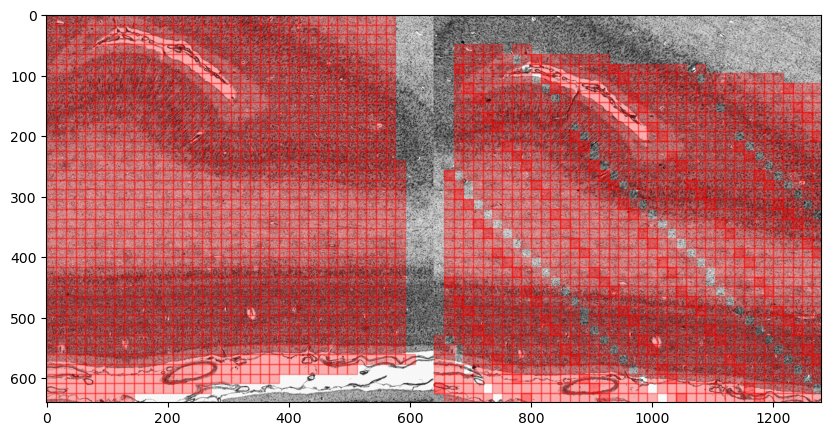

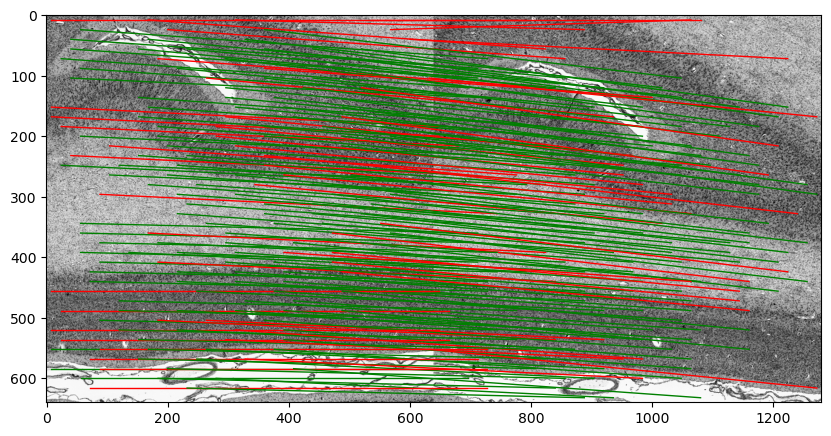

In [16]:
plot_images_with_matches_via_match_matrix(image_1=image_1_crop[0].cpu(), 
                                          image_2=image_2_crop[0].cpu(), 
                                          ground_truth_match_matrix=match_matrix_ground_truth[0].cpu(), 
                                          predicted_match_matrix=None, visualization_mode="patches", line_frequency=50)
plot_images_with_matches_via_match_matrix(image_1=image_1_crop[0].cpu(), 
                                          image_2=image_2_crop[0].cpu(), 
                                          ground_truth_match_matrix=match_matrix_ground_truth[0].cpu(), 
                                          predicted_match_matrix=coarse_matches_predicted["match_matrix"][0].cpu(), visualization_mode="lines", line_frequency=5)


### The following code block is for using the relative coordinates to adjust the predicted coarse matches

In [17]:
from source.data_processing.patch_processing import get_patch_coordinates
from source.data_processing.transformations import translate_fine_to_coarse, translate_coarse_to_fine

# Get matched patches in crop 1 and crop 2
crop_1_patch_indices_predicted = match_matrix_predicted[0].nonzero()[:, 0].cpu()  # Get all patch indices in crop 1
crop_2_patch_indices_predicted = match_matrix_predicted[0].nonzero()[:, 1].cpu() # Get all patch indices in crop 2

half_patch_size = patch_size // 2
# Get mid point of patches in crop 1 and crop 2
crop_1_patch_mid_indices_predicted = (
    get_patch_coordinates(patch_indices=crop_1_patch_indices_predicted)
    + torch.Tensor([half_patch_size, half_patch_size]).long()
)  # Get all patch coordinates in crop 1 and add 8 to get the mid point of the patch
crop_2_patch_mid_indices_predicted = (
    get_patch_coordinates(patch_indices=crop_2_patch_indices_predicted)
    + torch.Tensor([half_patch_size, half_patch_size]).long()
)  # Get all patch coordinates in crop 2 and add 8 to get the mid point of the patch

# Translate mid points in crop 1 and crop 2 (image space) to fine feature space
crop_2_patch_mid_indices_fine_predicted = translate_fine_to_coarse(
    fine_coordinates=crop_2_patch_mid_indices_predicted, fine_size=640, coarse_size=160)

window_size = 5
offset = predicted_relative_coordinates.cpu() * ((window_size - 1) / 2)

# Reproduced coordinates of matches in crop 2
predicted_matches_crop_2 = translate_coarse_to_fine(
    coarse_coords=crop_2_patch_mid_indices_fine_predicted.cpu() + offset,
    coarse_size=160,
    fine_size=640,
)

# Find the ground truth matches in crop 2
ground_truth_matches_crop_2 = crop_coordinate_mapping[0, 
    crop_1_patch_mid_indices_predicted[:, 1], crop_1_patch_mid_indices_predicted[:, 0]
]

There is one remaining problem: __ground_truth_matches_crop_2__ contains some [-1,-1] coordinates. That means that a pixel (i,j) is not part of crop_2. We will only compare coordinates between __ground_truth_matches_crop_2__ and __predicted_matches_crop_2__ where the pixel in crop_2 actually **exists**

In [18]:
pixel_exists_mask = (ground_truth_matches_crop_2 != -1).all(dim=1)

In [19]:
ground_truth_matches_crop_2 = ground_truth_matches_crop_2[pixel_exists_mask]
predicted_matches_crop_2 = predicted_matches_crop_2[pixel_exists_mask]
crop_2_patch_mid_indices_predicted = crop_2_patch_mid_indices_predicted[pixel_exists_mask]

In [20]:
torch.norm(ground_truth_matches_crop_2-predicted_matches_crop_2, dim=1).mean()

tensor(9.5687)

In [21]:
torch.norm(ground_truth_matches_crop_2-crop_2_patch_mid_indices_predicted, dim=1).mean()

tensor(10.2426)